# Text classification with an RNN

This is a text classification that uses recurrent neural network on the IMDB large movie review dataset for sentiment analysis.


_source_: https://www.tensorflow.org/text/tutorials/text_classification_rnn


<img src="https://www.tensorflow.org/text/tutorials/images/bidirectional.png" alt="mage.png" width="500" height="300" style="display: block; margin: 0 auto" />
<center>Design of the Model</center>

In [55]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [56]:
tfds.disable_progress_bar()

## Helpers functions

In [57]:
def plot_history_metric(history, metric):
    """
    Plot metric of model train by epochs history.
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

## Setup input pipeline

In [58]:
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True, shuffle_files=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

In [59]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

#### Take one text example and its label. 

In [89]:
example_text, example_label = "", ""
for text, label in train_dataset.take(1):
    example_text = text.numpy()
    example_label = label.numpy()

__Text Example:__

In [90]:
print(example_text)

b"This was soul-provoking! I am an Iranian, and living in th 21st century, I didn't know that such big tribes have been living in such conditions at the time of my grandfather!<br /><br />You see that today, or even in 1925, on one side of the world a lady or a baby could have everything served for him or her clean and on-demand, but here 80 years ago, people ventured their life to go to somewhere with more grass. It's really interesting that these Persians bear those difficulties to find pasture for their sheep, but they lose many the sheep on their way.<br /><br />I praise the Americans who accompanied this tribe, they were as tough as Bakhtiari people."


__Label Example:__

In [91]:
print(example_label)

1


## Shuffle the data for train and create batches of these (text, label) pairs

In [45]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [46]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [47]:
for example, label in train_dataset.take(1):
    print("texts: ", example.numpy()[:3],)
    print("labels: ", label.numpy()[:3])

texts:  [b'This story is a complex and wonderful tale of the last Harem of the Ottoman empire, well told and provoking we see the inner workings of a world now gone, and learn about the people who lived there.<br /><br />I enjoyed the story, characters, acting and scenes. A few scenes suffered from quick editing and the sub titles sometimes disappeared too quickly, otherwise a wonderful piece.<br /><br />The main character Safiya is played wonderfully by Marie Gillain who I am pleased to say did a fantastic job without over doing it. The scenes with her and Alex Descas (Nadir) are charming and lovely.<br /><br />I recommend this film for anybody looking to watch something less Hollywood and more authentic to the world they are emulating.'
 b"...but the actress playing the daughter just doesn't come across as credible.<br /><br />It doesn't work for me when I see an actress of about 25 years playing the role of a 12-year-old... Other commentators have suggested that this is one of the m

## Create the text encoder

In [9]:
VOCAB_SIZE = 1000

encoder_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder_layer.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder_layer(example)[:3].numpy()
encoded_example

array([[ 11,   7,  29, ...,   0,   0,   0],
       [ 41,  39, 464, ...,   0,   0,   0],
       [195, 203, 199, ...,   0,   0,   0]])

In [12]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("--------------------------------")
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'This is one of the best films we watched in my high school Spanish class. If you are a fan of the opera, this film will strongly entertain you. Of course, the dancing is wonderful. Watching these amazing dancers moving to the music of Bizet is well worth checking out.'
--------------------------------
Round-trip:  this is one of the best films we watched in my high school [UNK] class if you are a fan of the [UNK] this film will [UNK] [UNK] you of course the [UNK] is wonderful watching these amazing [UNK] moving to the music of [UNK] is well worth [UNK] out                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Create the model

In [13]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(encoder_layer.get_vocabulary()),
    output_dim=64,
    mask_zero=True)

In [14]:
model = tf.keras.Sequential([
    encoder_layer,
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


### Predict on a sample text without padding

In [16]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00935572]


### Predict on a sample text with padding

In [17]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00935572]


### Compile the Keras model to configure the training process

In [18]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

## Train the model

In [19]:
history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1137s 3s/step - loss: 0.6459 - accuracy: 0.5635 - val_loss: 0.4888 - val_accuracy: 0.7594
Epoch 2/10
391/391 [==============================] - 1136s 3s/step - loss: 0.4212 - accuracy: 0.8013 - val_loss: 0.3595 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 1172s 3s/step - loss: 0.3551 - accuracy: 0.8416 - val_loss: 0.3244 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 1096s 3s/step - loss: 0.3314 - accuracy: 0.8566 - val_loss: 0.3171 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 1146s 3s/step - loss: 0.3184 - accuracy: 0.8620 - val_loss: 0.3122 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 1123s 3s/step - loss: 0.3100 - accuracy: 0.8678 - val_loss: 0.3059 - val_accuracy: 0.8677
Epoch 7/10
391/391 [==============================] - 1108s 3s/step - loss: 0.3082 - accuracy: 0.8662 - val_loss: 0.3012 - val_accuracy:

In [ ]:
tf.keras.models.save_model(
    model, pat)

In [39]:
reconstructed_model = tf.keras.models.load_model("model/text_classification_sentiment_analysis_model")

2022-03-09 23:00:58.119492: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-09 23:00:58.734634: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-09 23:00:58.752831: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-09 23:00:59.611117: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-03-09 23:01:00.210072: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but 

ValueError: The mask that was passed in was tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64)) and cannot be applied to RaggedTensor inputs. Please make sure that there is no mask passed in by upstream layers.

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

391/391 [==============================] - 223s 571ms/step - loss: 0.3150 - accuracy: 0.8589
Test Loss: 0.31499743461608887
Test Accuracy: 0.8588799834251404


(0.0, 0.6634232521057128)

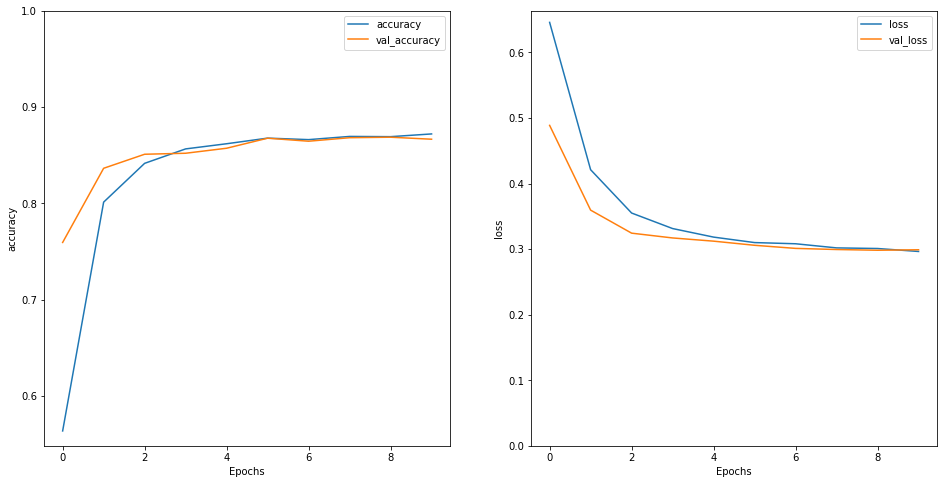

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### Prediction on a new sentence

In [29]:
ample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

print(predictions)

[[0.93420345]]
